# Processing chain: DWD radar data (Precipitation scans).

Daniel Sanchez-Rivas<sup>1</sup>

<sup>1</sup>Department of Meteorology, University of Bonn, Bonn, Germany

This notebook describes the process of retrieving, quality-checking, and processing raw C-band radar data collected by the operational DWD (Deutscher Wetterdienst) radar network.

If you think this repository is helpful, it would be awesome if you could cite the [Towerpy paper](https://www.sciencedirect.com/science/article/pii/S1364815223001329):

> @article{sanchezrivas2023, title = {{Towerpy: An open-source toolbox for processing polarimetric weather radar data}}, journal = {Environmental Modelling & Software}, pages= {105746}, year = {2023}, issn = {1364-8152}, doi = {https://doi.org/10.1016/j.envsoft.2023.105746}, author = {Daniel Sanchez-Rivas and Miguel Angel Rico-Ramirez}, keywords = {Weather radar, Polarimetry, Radar QPE, Radar research applications, Open source}}

I have the python script (*.py) version of this notebook available in this same directory [/radar/radproc/radchain_dwd.py/].

### Import relevant packages

In [1]:
import datetime as dt
import sys
import numpy as np
import towerpy as tp
import wradlib as wrl
from wradlib.dp import phidp_kdp_vulpiani as kdpvpi
import cartopy.crs as ccrs
LWDIR = '/home/dsanchez/sciebo_dsr/'
sys.path.append(LWDIR + 'codes/github/unibonnpd/')
from radar import twpext as tpx

/home/dsanchez/mambaforge/envs/towerpy/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)



You are using the Towerpy framework, an open source library for
working with polarimetric weather radar data.

If you find our work useful for your research, please consider citing our
following publication:

https://doi.org/10.1016/j.envsoft.105746.2023



### Define date, time, radar site and scan elevation

In [2]:
START_TIME = dt.datetime(2021, 7, 14, 0, 0)

STOP_TIME = START_TIME + dt.timedelta(hours=24)

RADAR_SITE = 'Essen'

SCAN_ELEV = 'ppi_pcp'

### List radar files

In [3]:
RS_FILES = tpx.get_listfilesdwd(RADAR_SITE, START_TIME, STOP_TIME,
                               scan_elev=SCAN_ELEV)

The `get_listfilesdwd` function generates a list of files, with each element representing a 5-minute interval for the precipitation scan. Each of these elements contains radar variables relevant to that specific time frame. This approach ensures that all data is organised chronologically. 

`PLOT_METHOD` determines whether the plots and results of the methods are to be plotted.

In [4]:
PLOT_METHODS = True

### Import data into towerpy using wradlib

The 212th element of the list of files, as retrieved from the `RS_FILES` variable, contains data corresponding to heavy rain recorded at 17:40 h. This will be the data point used in this example.

The Rad_scan class initialises a radar object.

The `ppi_dwd` function provides an interface to read the DWD radar data based on wradlib. The `get_rvar` argument enables retrieval of "high-priority" polarimetric variables, whereas the `get_rawvars' argument defines if raw variables are to be retrieved.

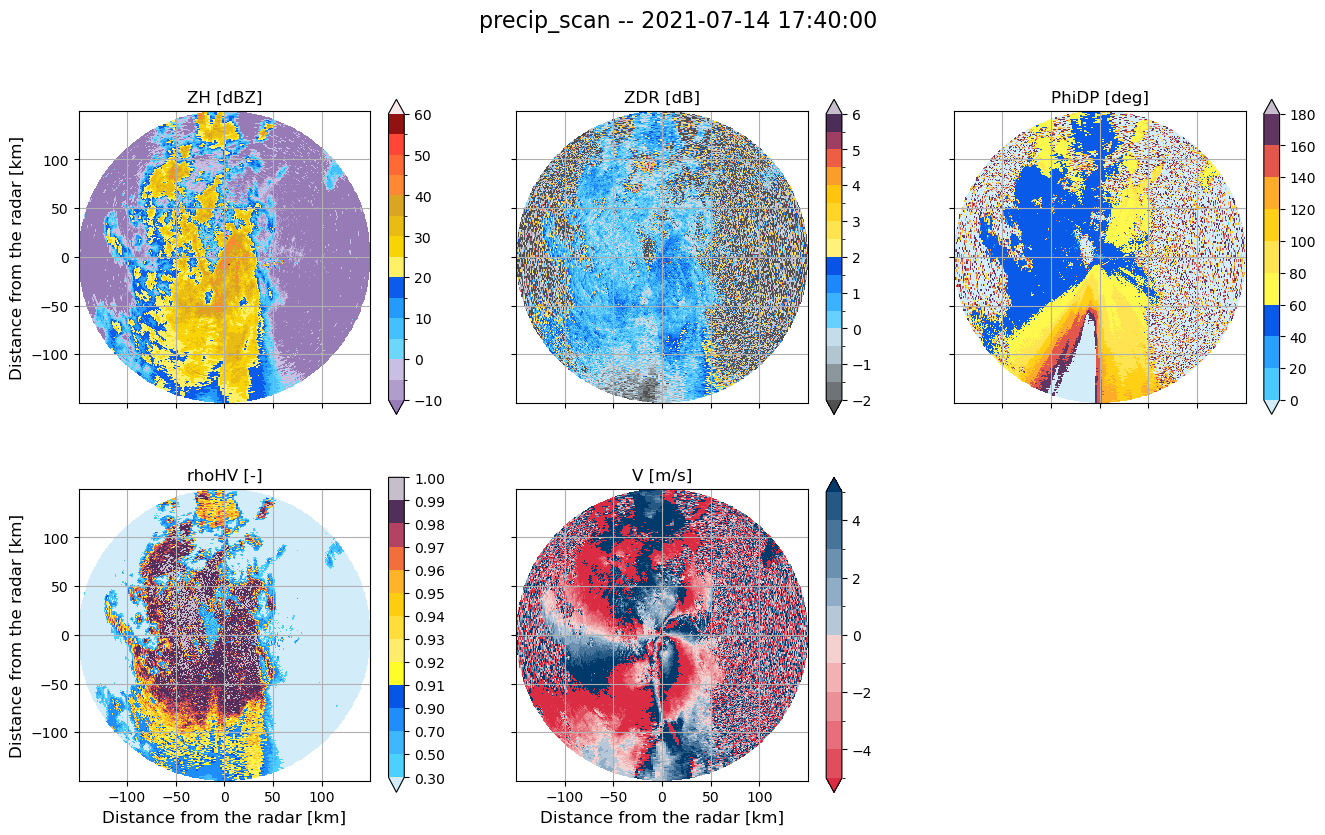

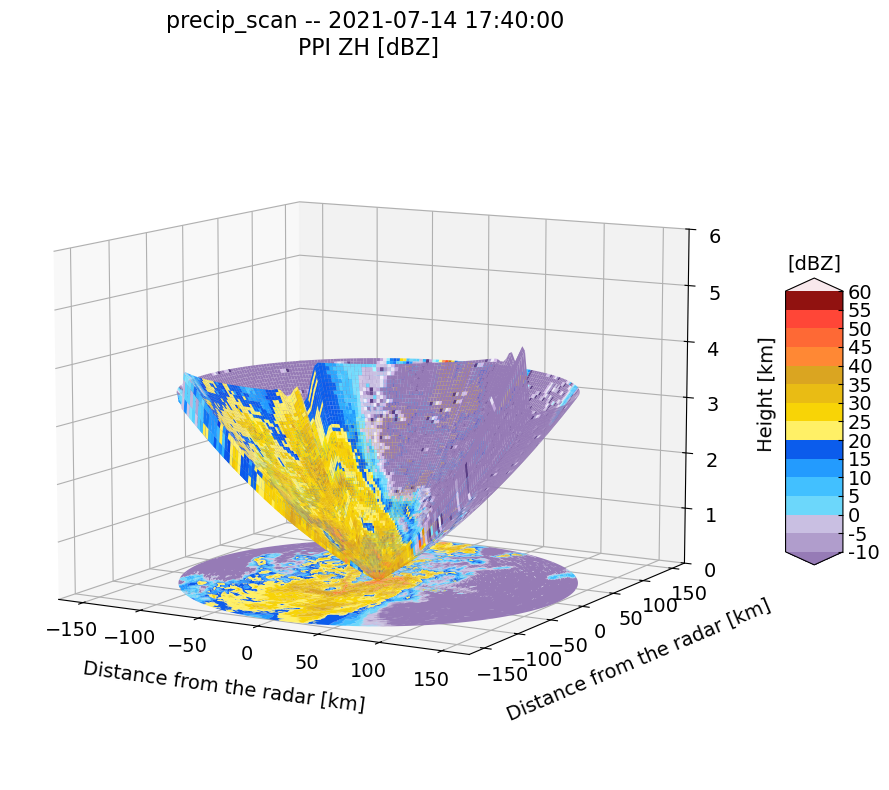

In [5]:
LPFILE = RS_FILES[212]

rdata = tpx.Rad_scan(LPFILE, f'{RADAR_SITE}')
rdata.ppi_dwd(get_rvar='pvars', get_rawvars=True)

tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params, rdata.vars)
if PLOT_METHODS:
    # Plot cone coverage
    tp.datavis.rad_display.plot_cone_coverage(rdata.georef, rdata.params,
                                              rdata.vars,
                                              # var2plot='PhiDP [deg]',
                                              # var2plot='V [m/s]',
                                              # var2plot='rhoHV [-]',
                                              # var2plot='ZDR [dB]',
                                              limh=6,  zlims=[0, 6])

### Correlation coefficient $(\rho_{HV})$ noise-correction

The process involves adjusting the radar constant (C) until a consistent relationship between the Signal-to-Noise Ratio (SNR) and the $\rho_{HV}$ is established, as outlined in **Ryzhkov and Zrnic (2019)**. For my particular implementation, a theoretical distribution of $\rho_{HV}$ is utilised to identify the "flat" dependency.

The `noise_lvl` argument can be used to constrain the values where the noise value is to be found. Additionally, the `data2correct` argument creates a copy of the original data, generating a new dictionary that includes the updated radar variables. 

The `rhohv_theo` argument may vary depending on the scan elevation...

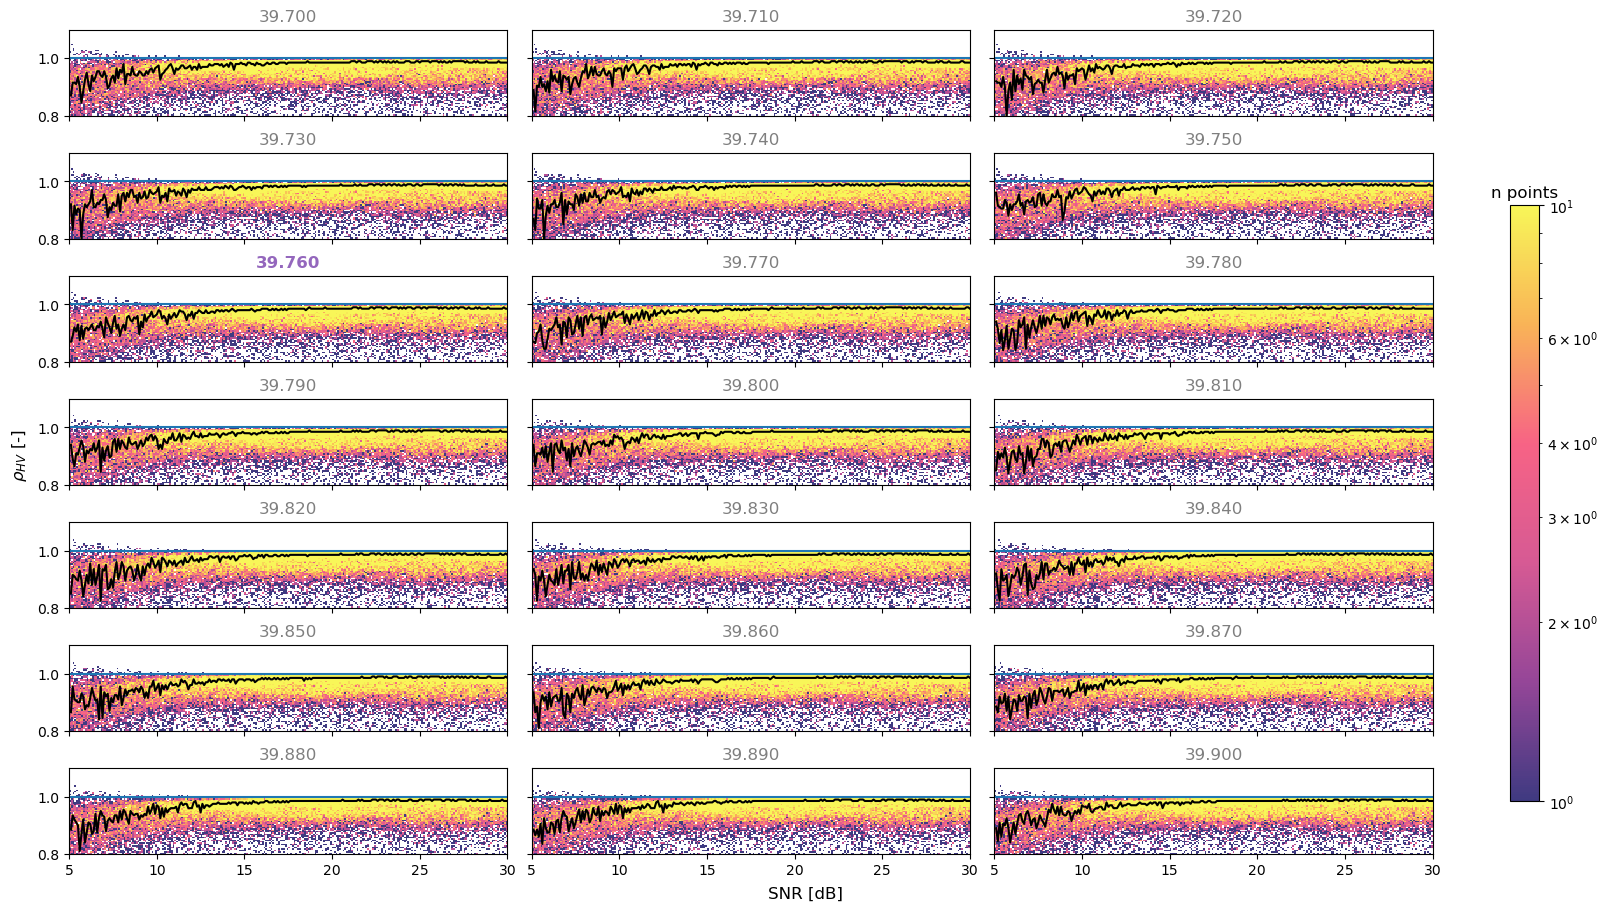

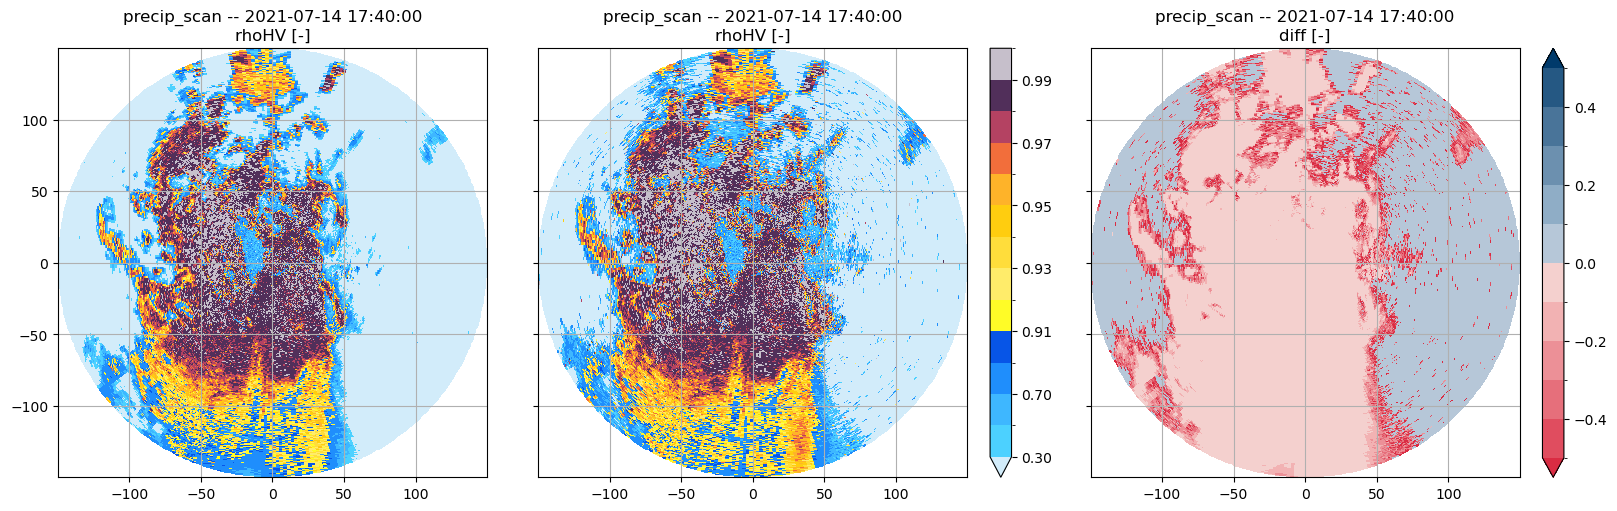

In [6]:
rhohv_theo, noise_lvl = (0.90, 1.1), None  # precip_scan

rcrho = tpx.rhoHV_Noise_Bias(rdata)
rcrho.iterate_radcst(rdata.georef, rdata.params, rdata.vars,
                     rhohv_theo=rhohv_theo, noise_lvl=noise_lvl,
                     data2correct=rdata.vars, plot_method=PLOT_METHODS)

if PLOT_METHODS:
    tp.datavis.rad_display.plot_ppidiff(
        rdata.georef, rdata.params, rdata.vars, rcrho.vars,
        var2plot1='rhoHV [-]', var2plot2='rhoHV [-]',
        ucmap_diff='tpylsc_div_dbu_rd', diff_lims=[-0.5, 0.5, .1])

### Noise suppression

I use the `signalnoiseratio` function to compute the Signal-to-Noise Ratio (SNR) in decibels (dB), which helps me quantify the level of desired signal compared to the background noise and get rid of noisy data. I use the reference noise value calculated in the $\rho_{HV}$ noise correction. By combining these two methods, I ensure that the noise level is accurately determined.

minSNR = 39.76 dB


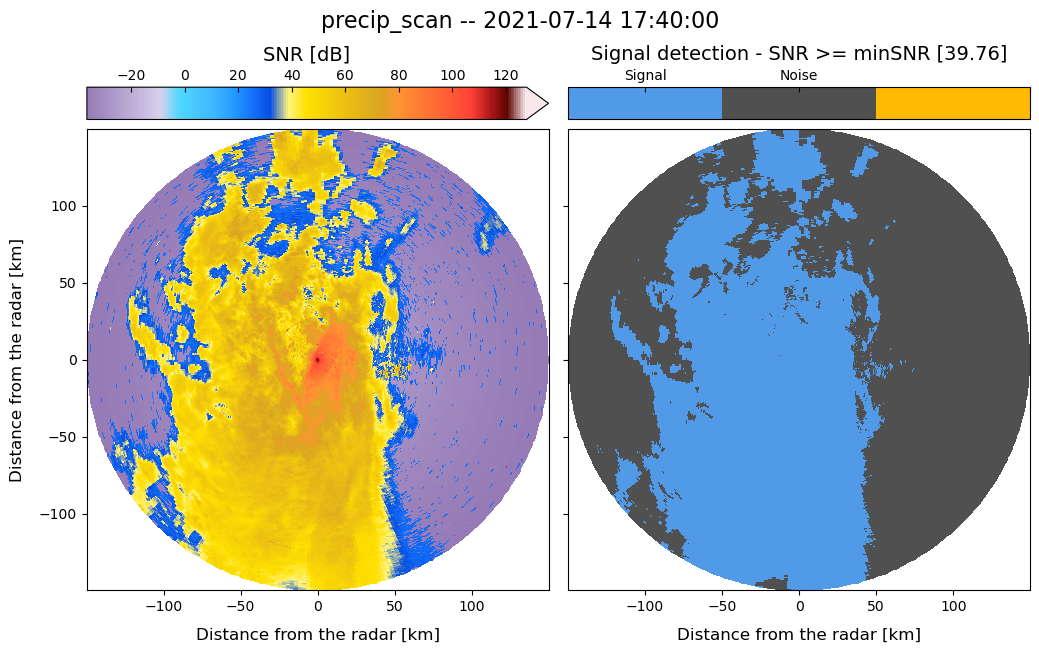

In [7]:
rsnr = tp.eclass.snr.SNR_Classif(rdata)
if rdata.params['radar constant [dB]'] <= 0:
    min_snr = -rcrho.rhohv_corrs['Noise level [dB]']
else:
    min_snr = rcrho.rhohv_corrs['Noise level [dB]']
print(f"minSNR = {min_snr:.2f} dB")
rsnr.signalnoiseratio(rdata.georef, rdata.params, rcrho.vars, min_snr=min_snr,
                      data2correct=rcrho.vars, plot_method=PLOT_METHODS)

 ###  Differential phase $(\Phi_{DP})$ quality control and processing

In this step, I try to address two issues that may affect $\Phi_{DP}$:

(1) $\Phi_{DP}(0)$ : The `offsetdetection_ppi` function detects the value of $\Phi_{DP}(0)$, i.e. the $\Phi_{DP}$ offset. The preset argument can be used to constrain the values where the offset is to be found. 

(2) $\Phi_{DP}$ folding. I use the `unfold_phi` function from wradlib to unfold the differential phase.

Phi_DP(0) = 36.84


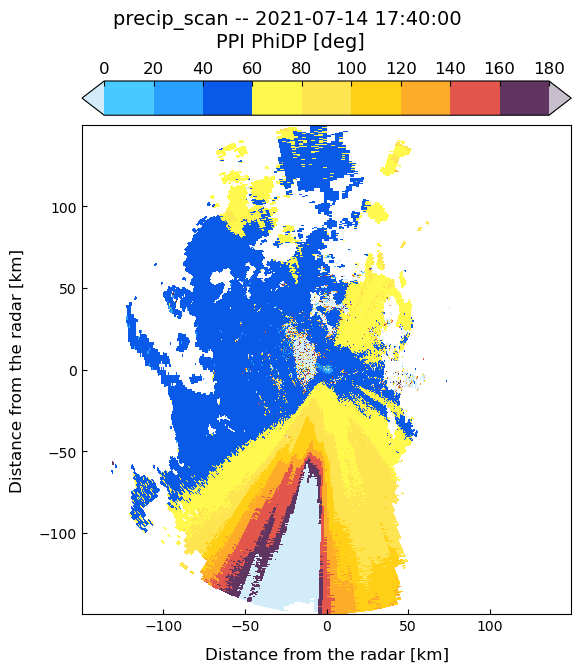

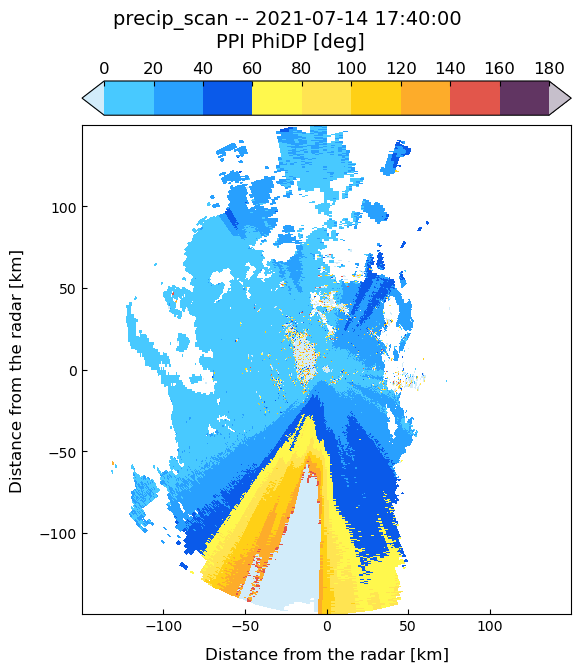

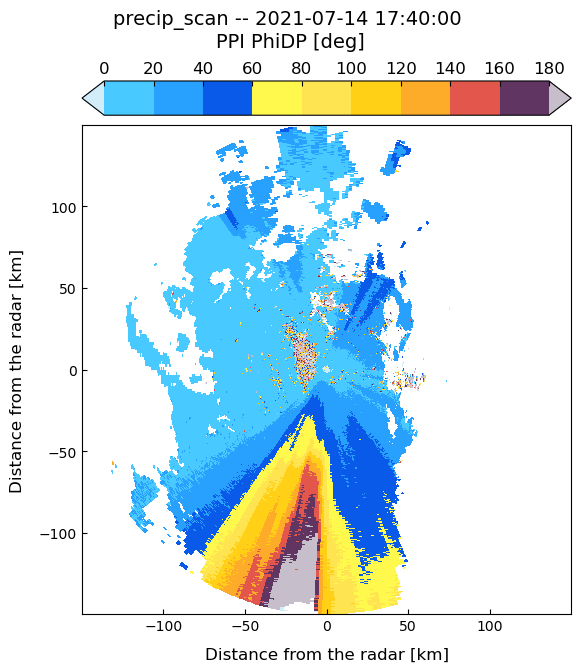

In [8]:
ropdp = tp.calib.calib_phidp.PhiDP_Calibration(rdata)

ropdp.offsetdetection_ppi(rsnr.vars, mode='median')
print(f'Phi_DP(0) = {np.median(ropdp.phidp_offset):.2f}')
ropdp.offset_correction(rsnr.vars['PhiDP [deg]'],
                        phidp_offset=ropdp.phidp_offset,
                        data2correct=rsnr.vars)

if PLOT_METHODS:
    tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rsnr.vars,
                                    var2plot='PhiDP [deg]')
    tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, ropdp.vars,
                                    var2plot='PhiDP [deg]')

ropdp.vars['PhiDP [deg]'] = np.ascontiguousarray(
    wrl.dp.unfold_phi(ropdp.vars['PhiDP [deg]'],
                      ropdp.vars['rhoHV [-]'],
                      width=3, copy=True).astype(np.float64))

if PLOT_METHODS:
    tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, ropdp.vars,
                                    var2plot='PhiDP [deg]')

### Non-meteorological echoes identification and removal

I use the `lsinterference_filter` function to despeckle the radar data and filter out linear signatures that may arise due to external interference.

Then, I apply the `clutter_id` function to identify ground clutter, sea clutter, and anomalous propagation echoes. This identification process relies on the methodology established by **Rico-Ramirez, M. A., & Cluckie, I. D. (2008)**. The clutter map generated by the DWD is used, when available, to improve the performance of the clutter identification algorithm. However, it is worth noting that this algorithm is robust enough to accurately identify NME (non-meteorological echoes) even without DWD clutter maps.

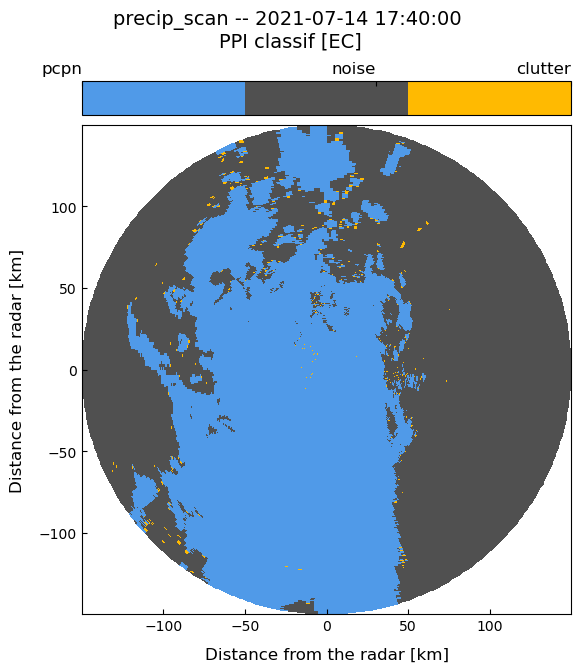

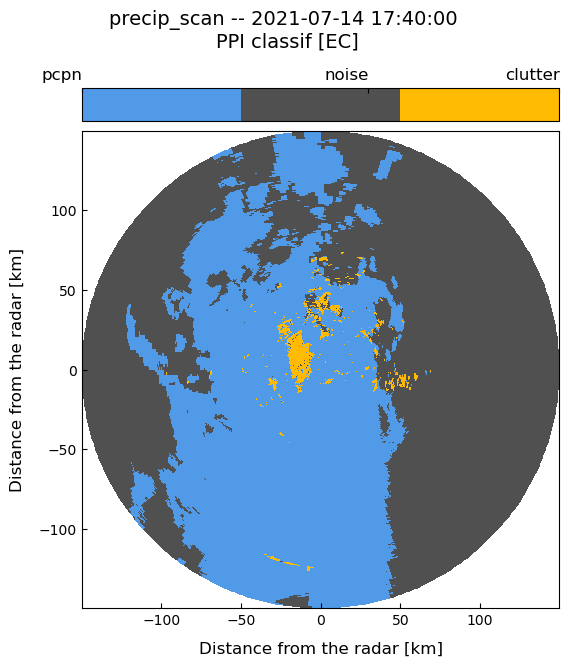

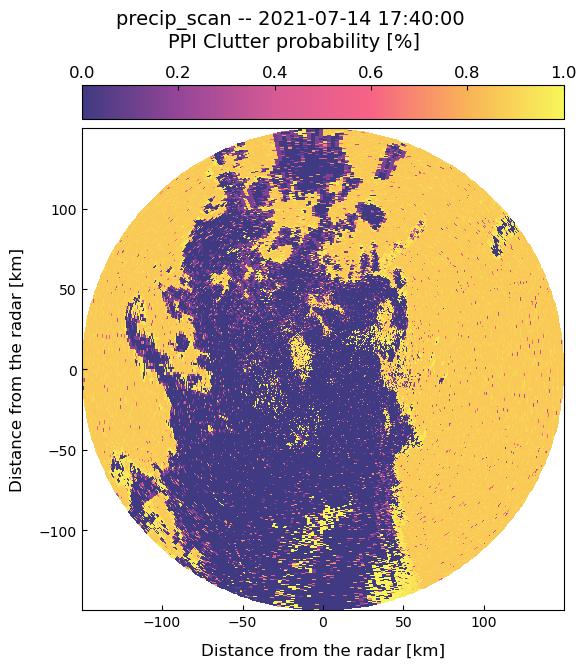

In [9]:
rdata2 = tpx.Rad_scan(LPFILE, f'{RADAR_SITE}')
# DWD clutter map is not always available, these lines try to read such data
try:
    rdata2.ppi_dwd(get_rvar='cmap')

    cmap = 1 - tp.utils.radutilities.normalisenanvalues(
        rdata2.vars['cmap [0-1]'], np.nanmin(rdata2.vars['cmap [0-1]']),
        np.nanmax(rdata2.vars['cmap [0-1]']))
    cmap = np.nan_to_num(cmap, nan=1e-5)
    bclass = 207
    pass
except Exception:
    cmap = None
    bclass = 207 - 64
    print('No CL Map available')
    pass

rnme = tp.eclass.nme.NME_ID(ropdp)
rnme.lsinterference_filter(rdata.georef, rdata.params, ropdp.vars,
                           rhv_min=0.3, data2correct=ropdp.vars,
                           plot_method=PLOT_METHODS)
rnme.clutter_id(rdata.georef, rdata.params, rnme.vars, binary_class=bclass,
                min_snr=rsnr.min_snr, clmap=cmap, data2correct=rnme.vars,
                plot_method=PLOT_METHODS)

### Melting layer allocation

A MeltingLayer object is used to define the height of the top and bottom of the melting layer. These heights are important to delimit the rain region within the PPI scan. I used QVPs to detect the melting layer boundaries, as described in **Sanchez-Rivas and Rico-Ramirez (2021)**. Thus, an isotropic melting layer is assumed.

The ml_ppidelimitation function creates a PPI depicting the limits of the melting layer.

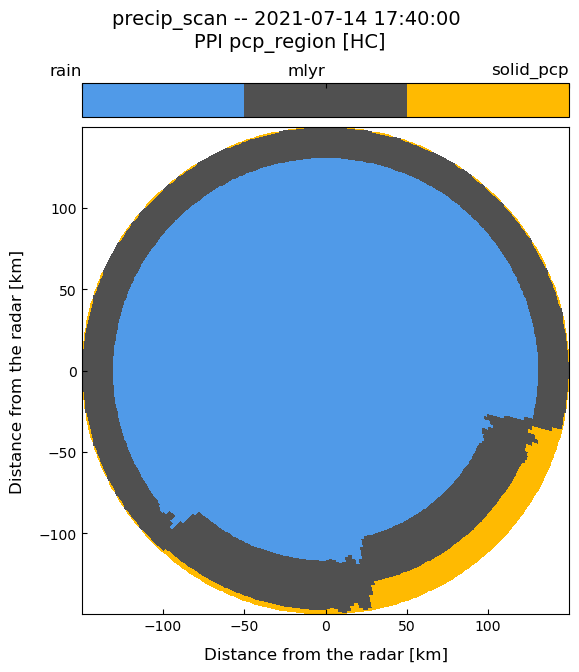

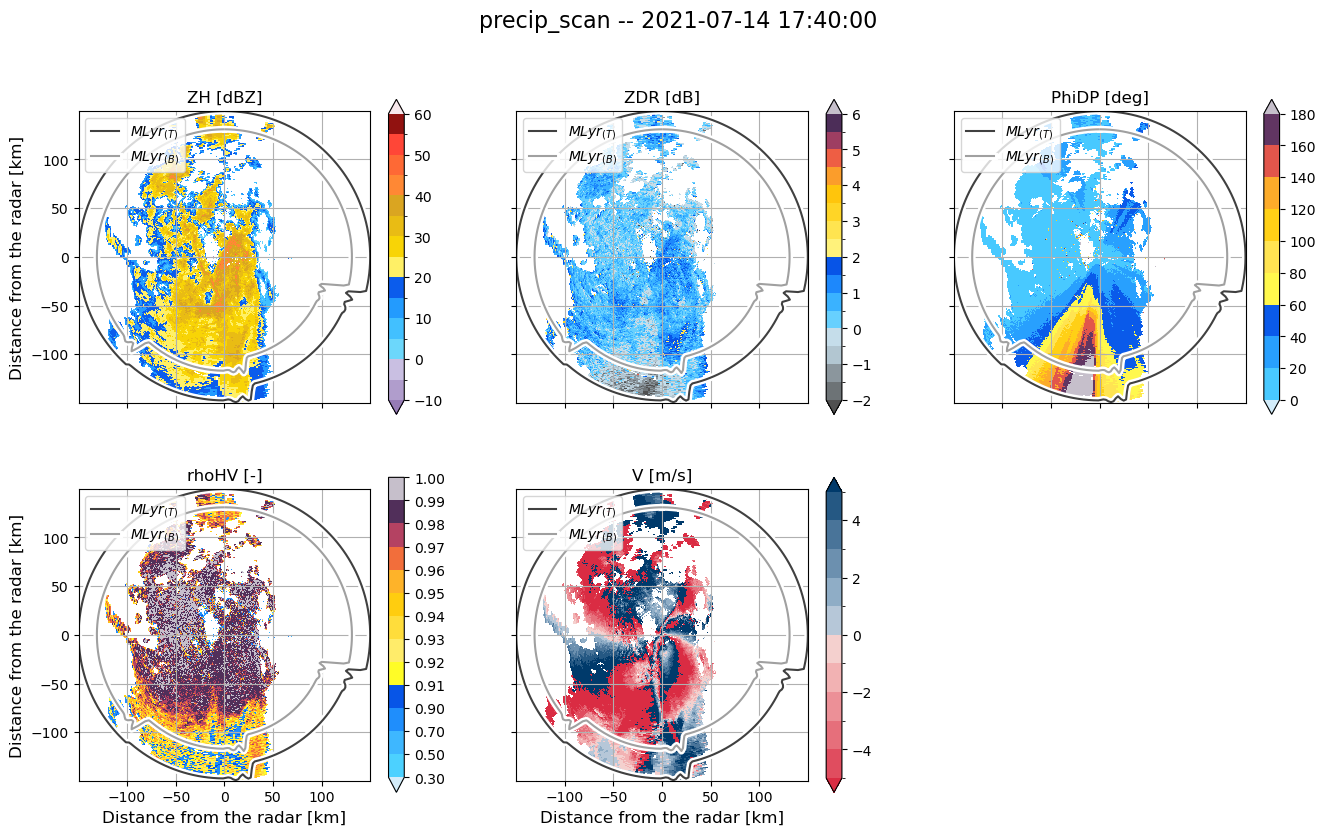

In [10]:
rmlyr = tp.ml.mlyr.MeltingLayer(rdata)
rmlyr.ml_top = 3.82
rmlyr.ml_bottom = 2.82
rmlyr.ml_thickness = rmlyr.ml_top - rmlyr.ml_bottom

rmlyr.ml_ppidelimitation(rdata.georef, rdata.params, rsnr.vars, 
                         plot_method=PLOT_METHODS)

if PLOT_METHODS:
    tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params, rnme.vars,
                                       mlyr=rmlyr)

### Differential reflectivity $(Z_{DR})$ offset correction

Similarly, the $Z_{DR}$ offset was computed from QVPs, as described in **Sanchez-Rivas and Rico-Ramirez (2022)**. For this case, the offset is set as -0.26 dB.

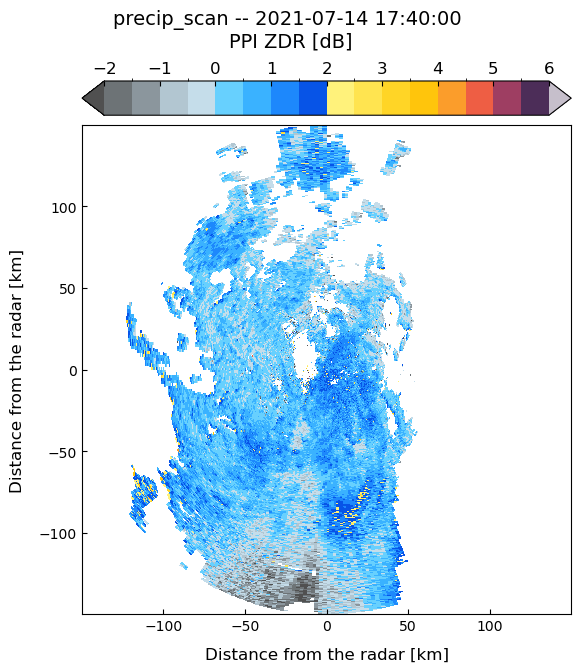

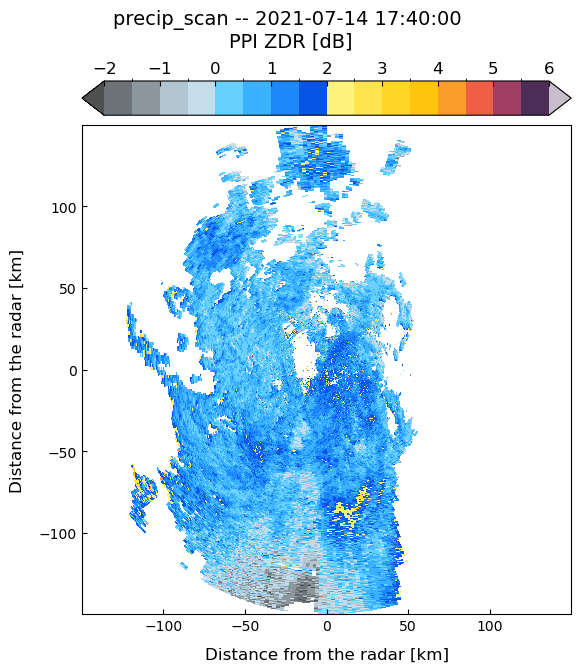

In [11]:
rozdr = tp.calib.calib_zdr.ZDR_Calibration(rdata)
rozdr.offset_correction(rnme.vars['ZDR [dB]'], zdr_offset=-0.26,
                        data2correct=rnme.vars)
if PLOT_METHODS:
    tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rnme.vars,
                                    var2plot='ZDR [dB]')
    tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rozdr.vars,
                                    var2plot='ZDR [dB]')


### Radar reflectivity $(Z_H)$ attenuation correction

The attenuation of $Z_H$ in the liquid phase of precipitation is addressed through a robust methodology proposed by **Rico-Ramirez, M. A. (2012).**

Initially, the differential phase $\Phi_{DP}$ undergoes a thorough processing sequence that includes smoothing, filtering, and interpolating of the signal phase. This is accomplished using the `attc_phidp_prepro` function, which refines the phase data.

The `zh_correction` function provides different methods to correct $Z_H$ for attenuation effects. I use the ABRI method, a ray-wise, optimised extension of the methodology proposed by Bringi, V. N. et al. (2001), where the optimal values of $a, b,$ and $\alpha$ are calculated, as proposed by **Rico-Ramirez, M. A. (2012)**. The ranges of values used to find the optimal values are adapted from **Diederich, M. et al (2015)**, **Rico-Ramirez, M. A. (2012)** and **Trömel et al. (2014)**. 

It is essential to highlight that attenuation calculation is restricted to the region up to the bottom of the melting layer within the PPI (Plan Position Indicator) scan.

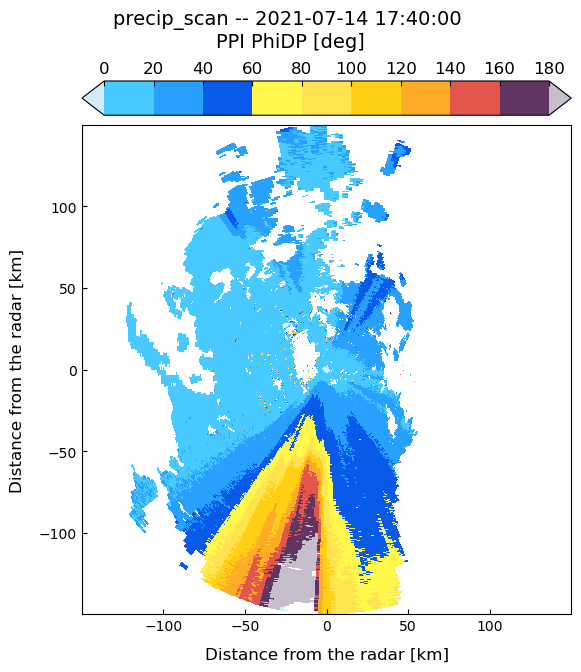

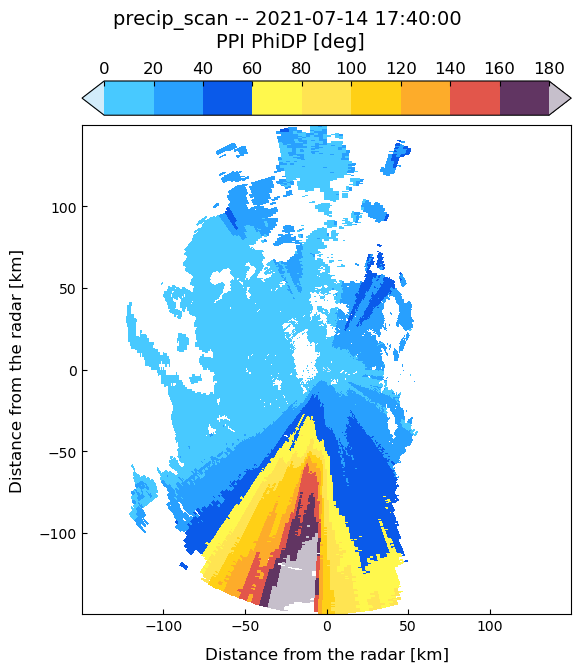

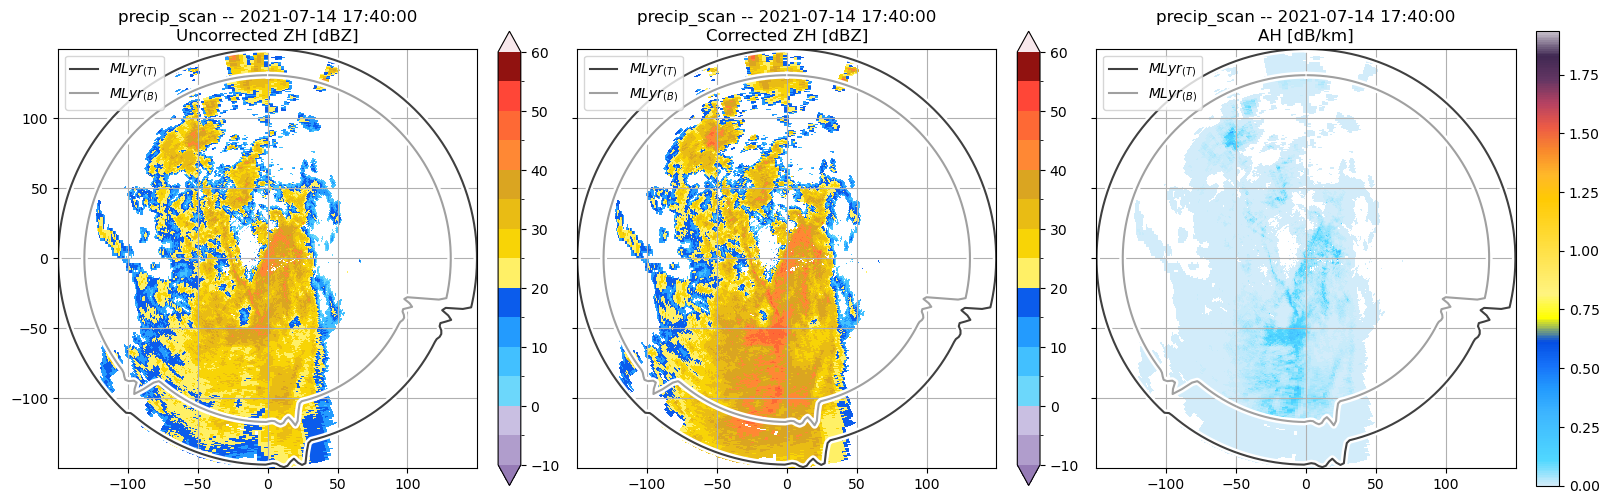

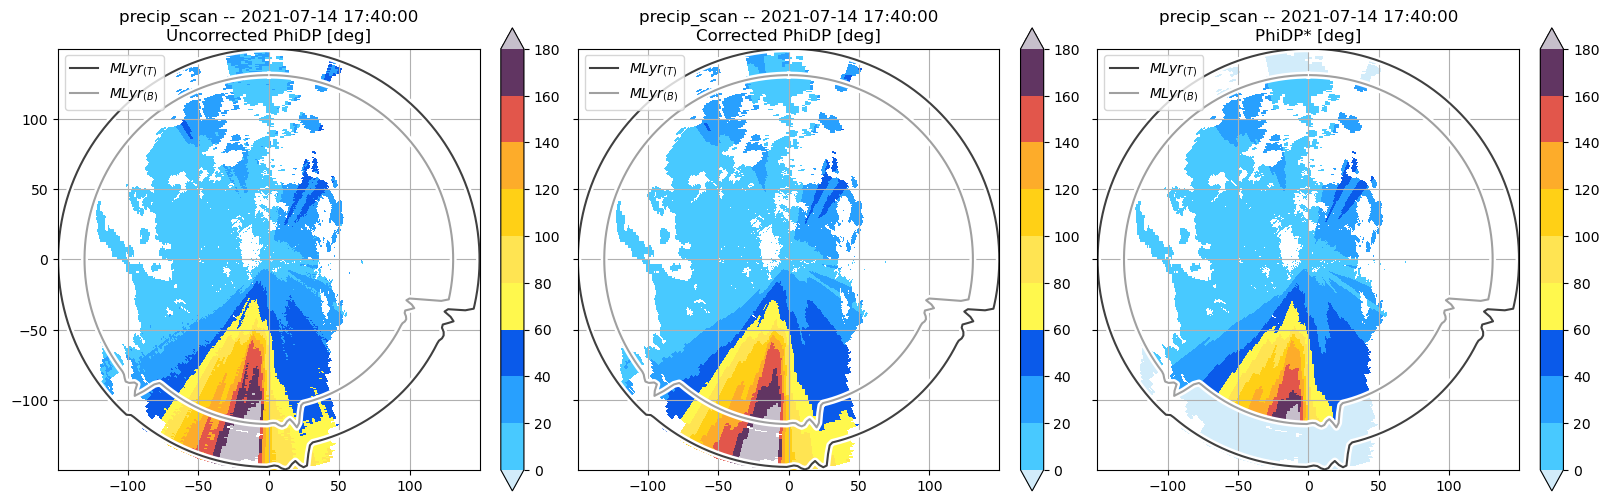

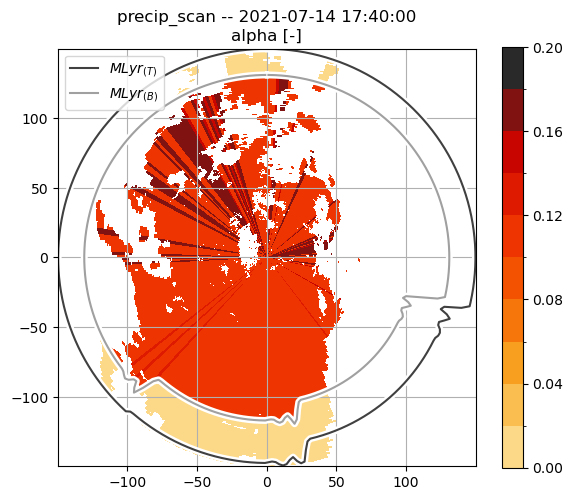

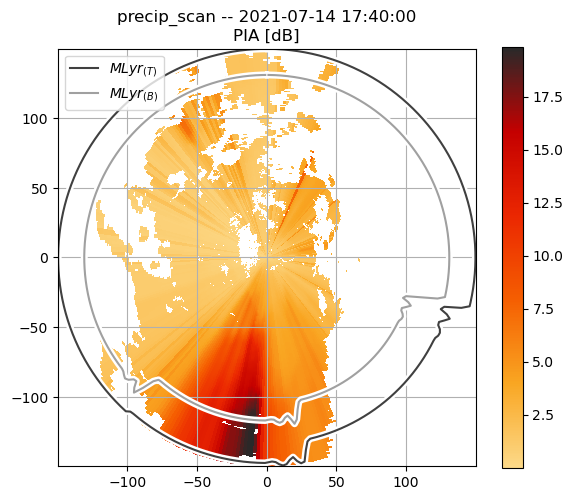

In [12]:
att_alpha = [0.05, 0.1, 0.08]  # Light to moderate rain
att_alpha = [0.1, 0.18, 0.08]  # Moderate to heavy rain

rattc = tp.attc.attc_zhzdr.AttenuationCorrection(rdata)

rattc.attc_phidp_prepro(
    rdata.georef, rdata.params, rozdr.vars, rhohv_min=0.85,
    phidp0_correction=(True if (rattc.site_name == 'Offenthal')
                               or (rattc.site_name == 'Flechtdorf')
                               or (rattc.site_name == 'Neuheilenbach')
                               else False))

if PLOT_METHODS:
    tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rozdr.vars,
                                    var2plot='PhiDP [deg]')
    tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rattc.vars,
                                    var2plot='PhiDP [deg]')

rattc.zh_correction(rdata.georef, rdata.params, rattc.vars,
                    rnme.nme_classif['classif [EC]'], mlyr=rmlyr, pdp_dmin=1,
                    attc_method='ABRI', pdp_pxavr_azm=3,
                    pdp_pxavr_rng=round(4000/rdata.params['gateres [m]']),
                    coeff_a=[1e-5, 4.27e-5, 3e-05],
                    coeff_b=[0.73, 0.85, 0.78],
                    coeff_alpha=att_alpha,
                    plot_method=PLOT_METHODS)

### Computation of $Z_H(A_H)$

Partial beam blockage, radar miscalibration, and wet radome effects are handled using the methodology introduced by **Diederich et al. (2015)**, which derives radar reflectivity $(Z_H)$ from specific attenuation $(A_H)$.

I set the temperature in the `rzhah.ah_zh` function to 15°C (a fair assumption for Germany during rain).

To ensure a smooth computation of $Z_H$ from $A_H$, I fine-tune the outputs by applying a moving average filter. I choose this approach because $A_H$ can sometimes show significant variability; the $A_H(Z_H)$ relationships are valid for $20 < Z_H < 50 dBZ$, which can result in visible streaks in the final results. By refining these outputs, I aim to achieve a smoother and more visually coherent representation of the data.

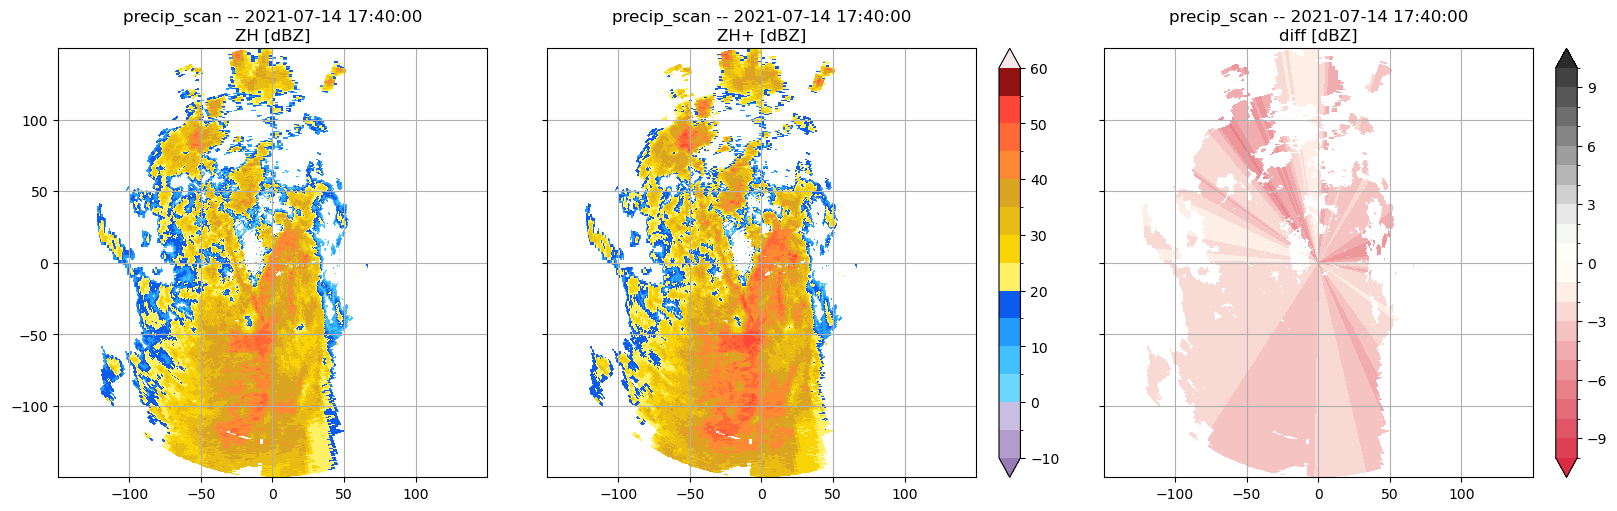

In [13]:
temp = 15

rzhah = tp.attc.r_att_refl.Attn_Refl_Relation(rdata)
rzhah.ah_zh(rattc.vars, zh_upper_lim=55, temp=temp, rband='C',
            copy_ofr=True, data2correct=rattc.vars)
rattc.vars['ZH* [dBZ]'] = rzhah.vars['ZH [dBZ]']

mov_avrgf_len = (1, 7)
zh_difnan = np.where(rzhah.vars['diff [dBZ]'] == 0, np.nan,
                     rzhah.vars['diff [dBZ]'])
zhpdiff = np.array([np.nanmedian(i) if ~np.isnan(np.nanmedian(i))
                    else 0 for cnt, i in enumerate(zh_difnan)])
zhpdiff_pad = np.pad(zhpdiff, mov_avrgf_len[1]//2, mode='wrap')
zhplus_maf = np.ma.convolve(
    zhpdiff_pad, np.ones(mov_avrgf_len[1])/mov_avrgf_len[1],
    mode='valid')
rattc.vars['ZH+ [dBZ]'] = np.array(
    [rattc.vars['ZH [dBZ]'][cnt] - i if i == 0
     else rattc.vars['ZH [dBZ]'][cnt] - zhplus_maf[cnt]
     for cnt, i in enumerate(zhpdiff)])

if PLOT_METHODS:
    tp.datavis.rad_display.plot_ppidiff(
        rdata.georef, rdata.params, rattc.vars, rattc.vars,
        var2plot1='ZH [dBZ]', var2plot2='ZH+ [dBZ]')

### $Z_{DR}$ attenuation correction

I correct the differential horizontal reflectivity for differential attenuation using a ray-wise optimised attenuation method adapted from **Bringi, V. N. et al. (2001)**.

The `zdr_correction` function requires the outputs of the attenuation correction (more specifically, parameter $\alpha$) to compute the specific differential attenuation $(A_{DP} [dB/km])$. Additionally, I use the $Z_H-Z_{DR}$ relation derived specifically for Germany by **Chen et. al. (2021)** to improve the outputs of this methodology. The $\beta/\alpha$ ratio is adapted from **Ryzhkov and Zrnic (2019)**.

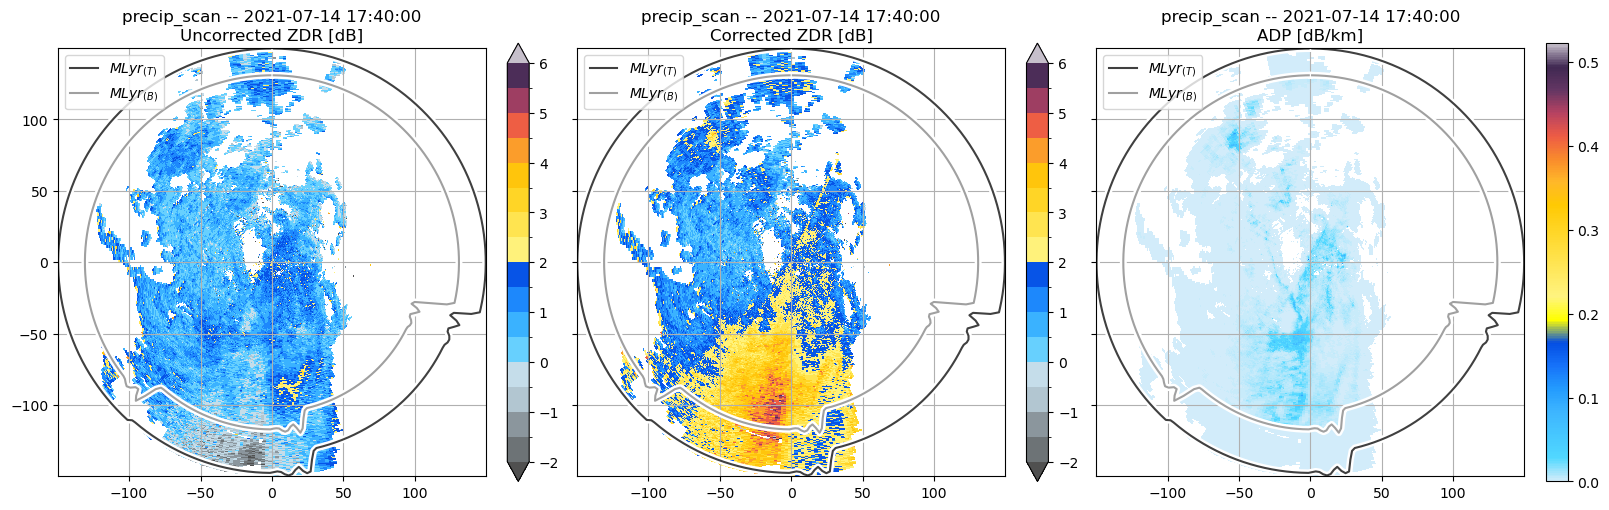

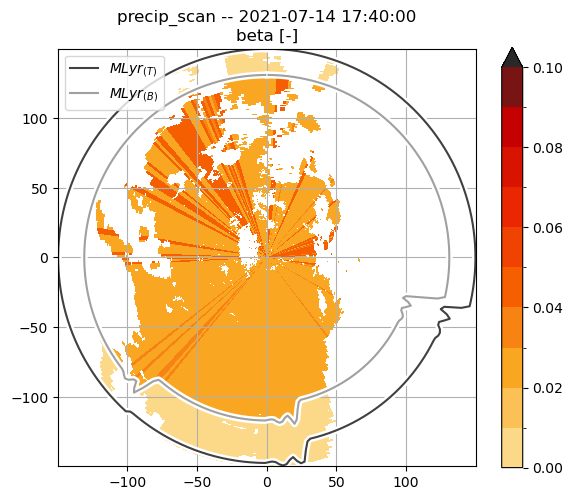

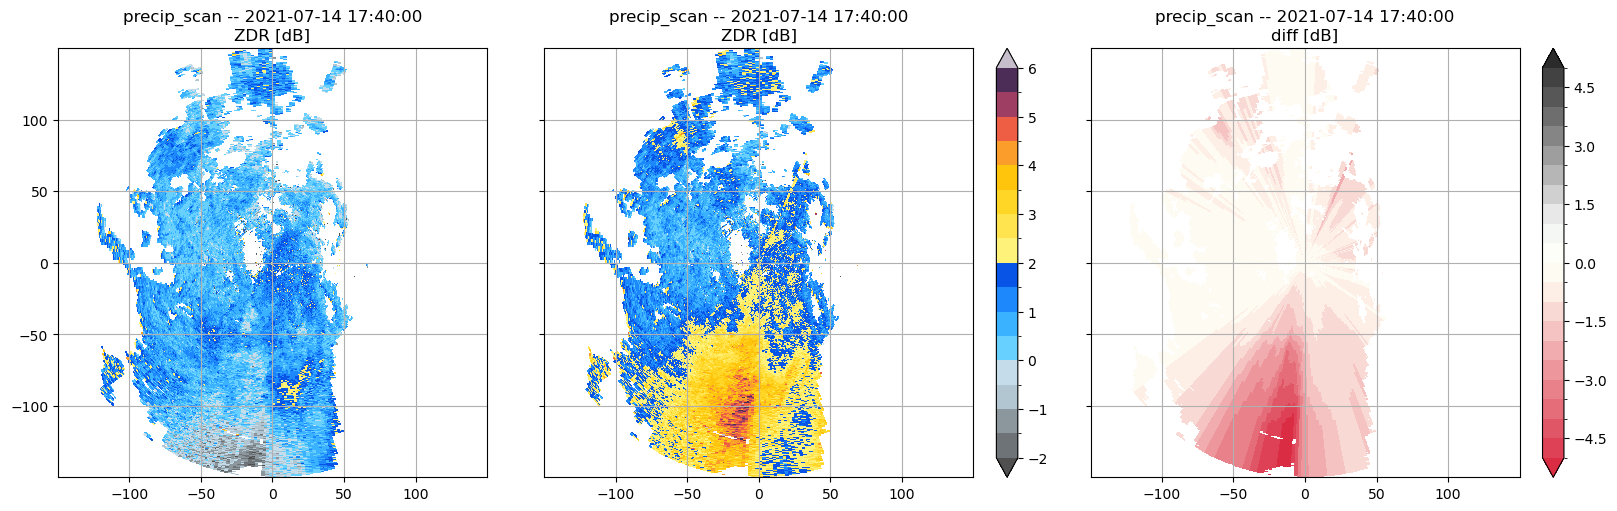

In [14]:
zhzdr_a = 0.000249173
zhzdr_b = 2.33327
rb_a = 0.39  # Continental
rb_a = 0.14  # Tropical
rb_a = 0.27  # mid

rattc.zdr_correction(rdata.georef, rdata.params, rozdr.vars, rattc.vars,
                     rnme.nme_classif['classif [EC]'], mlyr=rmlyr, descr=True,
                     coeff_beta=[0.008, 0.1, 0.02], beta_alpha_ratio=rb_a,
                     rhv_thld=0.98, mov_avrgf_len=9, minbins=5, p2avrf=3,
                     attc_method='BRI', zh_zdr_model='exp',
                     rparams={'coeff_a': zhzdr_a, 'coeff_b': zhzdr_b},
                     plot_method=PLOT_METHODS)
if PLOT_METHODS:
    tp.datavis.rad_display.plot_ppidiff(rdata.georef, rdata.params, rozdr.vars,
                                        rattc.vars, var2plot1='ZDR [dB]',
                                        var2plot2='ZDR [dB]',
                                        diff_lims=[-5, 5, .5])

### Specific differential phase $(K_{DP})$ calculation

I derive $K_{DP}$ through an integration of methodologies, specifically by combining the method used in wradlib, which adapts the technique proposed by **Vulpiani et al. (2012)**, with the $K_{DP}$ values derived from $A_H$. This relationship is expressed as follows:

$K_{DP}=A_H/\alpha$.

Calculating a ray-wise $\alpha$ allows for a reliable derivation of $K_{DP}$ using the previously mentioned relation.

It is noteworthy that $\Phi_{DP}$ has already undergone sufficient filtering and smoothing in earlier steps, allowing for a relatively small window size to be used in the `phidp_kdp_vulpiani` function, ensuring reliable and high-resolution values of $K_{DP}$.

In the rain region, negative $K_{DP}$ values are set to zero based on a threshold of 5 dBZ in $Z_H$.
I use thresholds on $Z_H$ (< 55 dBZ) and $\rho_{HV}$ (0.95) to address the potential but well-known impact of hail on $A_H$.

Combining these two methodologies enhances the resolution of this "synthetic" $K_{DP}$, making it nearly equivalent to the resolution of $A_H$ in high rain rates. This enhancement aims to improve the accuracy of quantitative precipitation estimation (QPE).

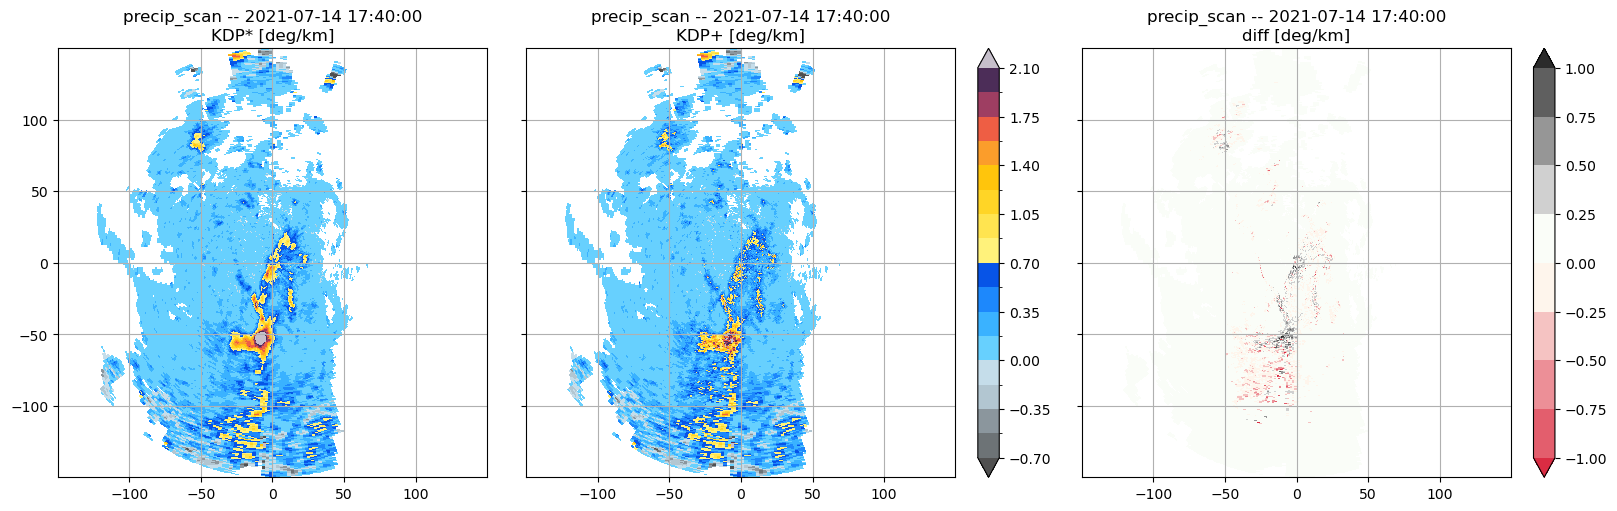

In [15]:
# KDP Vulpiani
zh_kdp = 'ZH+ [dBZ]'
rkdpv = {}
kdp_vulp = kdpvpi(rattc.vars['PhiDP [deg]'], winlen=3,
                  dr=rdata.params['gateres [m]']/1000, copy=True)
rkdpv['PhiDP [deg]'] = kdp_vulp[0]
rkdpv['KDP [deg/km]'] = kdp_vulp[1]

# Remove NME
rattc.vars['KDP* [deg/km]'] = np.where(rnme.ls_dsp_class['classif [EC]'] != 0,
                                       np.nan, rkdpv['KDP [deg/km]'])
# Remove negative KDP values within the rain region using a ZH threshold
rattc.vars['KDP* [deg/km]'] = np.where(
    (rmlyr.mlyr_limits['pcp_region [HC]'] == 1)
    & (rkdpv['KDP [deg/km]'] < 0) & (rattc.vars[zh_kdp] > 5),
    0, rattc.vars['KDP* [deg/km]'])
# Filter KDP by applying thresholds in ZH and rhoHV
rattc.vars['KDP+ [deg/km]'] = np.where(
    (rattc.vars[zh_kdp] >= 40) & (rattc.vars[zh_kdp] < 55)
    & (rozdr.vars['rhoHV [-]'] >= 0.95) & (rattc.vars['KDP [deg/km]'] != 0)
    & (~np.isnan(rattc.vars['KDP [deg/km]'])),
    rattc.vars['KDP [deg/km]'], rattc.vars['KDP* [deg/km]'])

if PLOT_METHODS:
    tp.datavis.rad_display.plot_ppidiff(
        rdata.georef, rdata.params, rattc.vars, rattc.vars,
        var2plot1='KDP* [deg/km]', var2plot2='KDP+ [deg/km]',
        diff_lims=[-1, 1, .25], vars_bounds={'KDP [deg/km]': (-0.7, 2.1, 17)})

### OUTPUT

Finally, I create a towerpy radar object to store the quality-controlled variables.

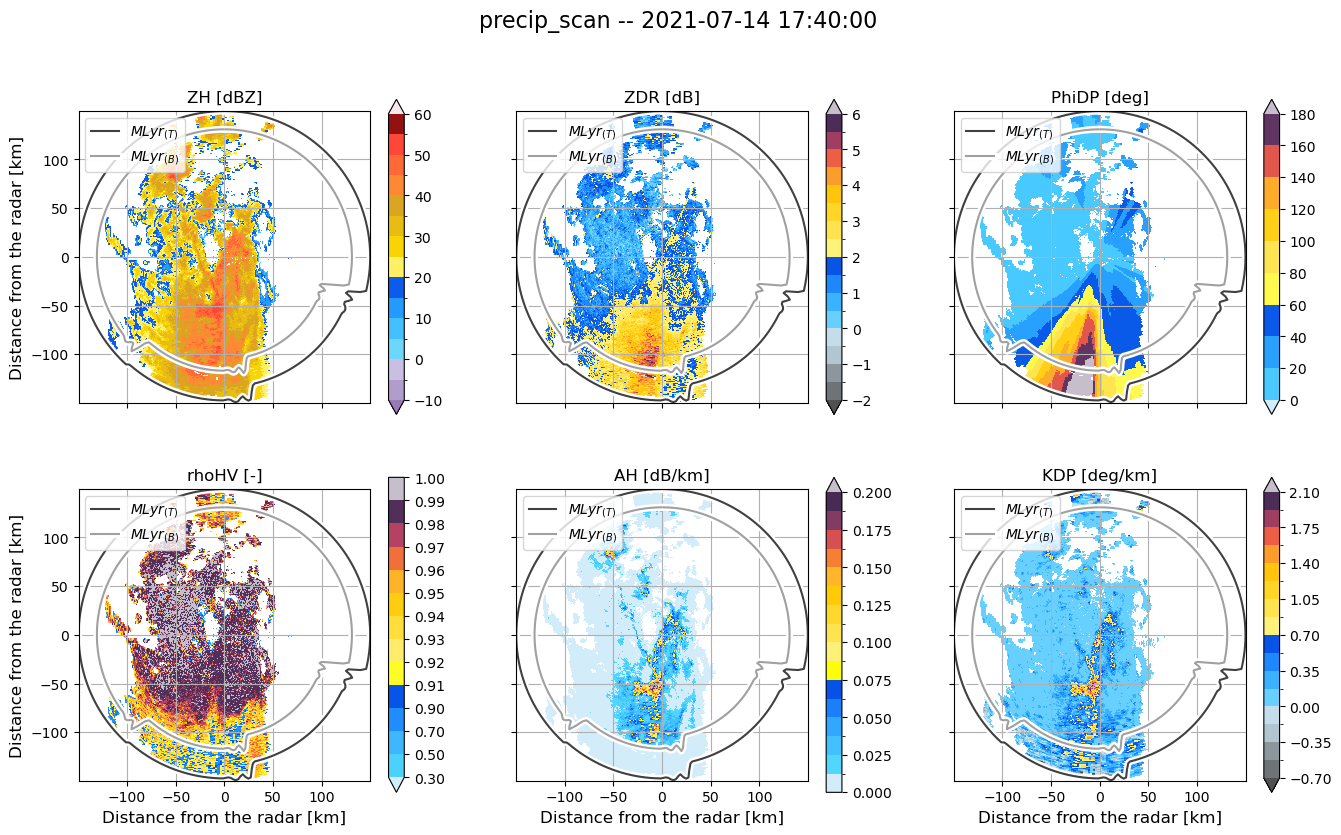

In [16]:
rd_qcatc = tp.attc.attc_zhzdr.AttenuationCorrection(rdata)
rd_qcatc.georef = rdata.georef
rd_qcatc.params = rdata.params
rd_qcatc.vars = dict(rattc.vars)

rd_qcatc.vars = {}
rd_qcatc.vars['ZH [dBZ]'] = rattc.vars['ZH+ [dBZ]']
rd_qcatc.vars['ZDR [dB]'] = rattc.vars['ZDR [dB]']
rd_qcatc.vars['PhiDP [deg]'] = rattc.vars['PhiDP [deg]']
rd_qcatc.vars['rhoHV [-]'] = rozdr.vars['rhoHV [-]']
rd_qcatc.vars['AH [dB/km]'] = rattc.vars['AH [dB/km]']
rd_qcatc.vars['KDP [deg/km]'] = rattc.vars['KDP+ [deg/km]']

if PLOT_METHODS:
    tp.datavis.rad_display.plot_setppi(rd_qcatc.georef, rd_qcatc.params,
                                       rd_qcatc.vars, mlyr=rmlyr,
                                       vars_bounds={'AH [dB/km]': [0, 0.2, 17],
                                                    'KDP [deg/km]': [-0.7, 2.1, 17]})

## The rad_interactive module

Check or uncheck the following line to enable the use of widgets in the notebook. *ipympl* is required.

In [21]:
# %matplotlib ipympl

This module helps explore the PPI scans. For instance, **the coordinates of the current position of the mouse pointer can be stored by pressing a number (0-9)**. This is useful for classifying pixels, e.g. 0 for meteorological echoes, 3 for noise and 5  for non-meteorological ones, in accordance with the *clutter_id* function.


 
 
  Right-click on a pixel within the PPI to select its 
  azimuth or use the n and m keys to browse through the next 
  and previous azimuth.                                      
  Radial profiles of polarimetric variables will be shown at 
  the axes on the right.                                     
  Press a number (0-9) to store the coordinates and value    
  of the current position of the mouse pointer.              
  These coordinate can be retrieved at                       
  ppiexplorer.clickcoords                                    


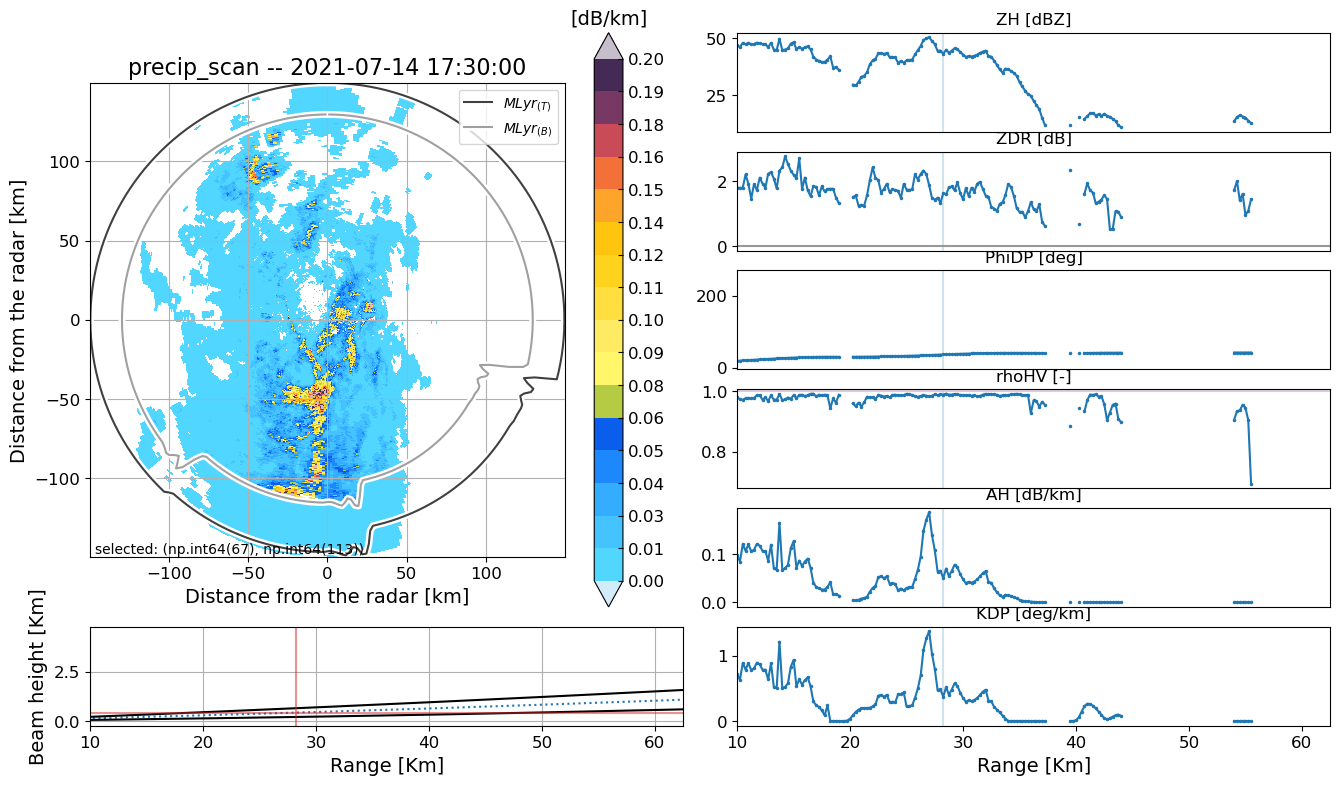

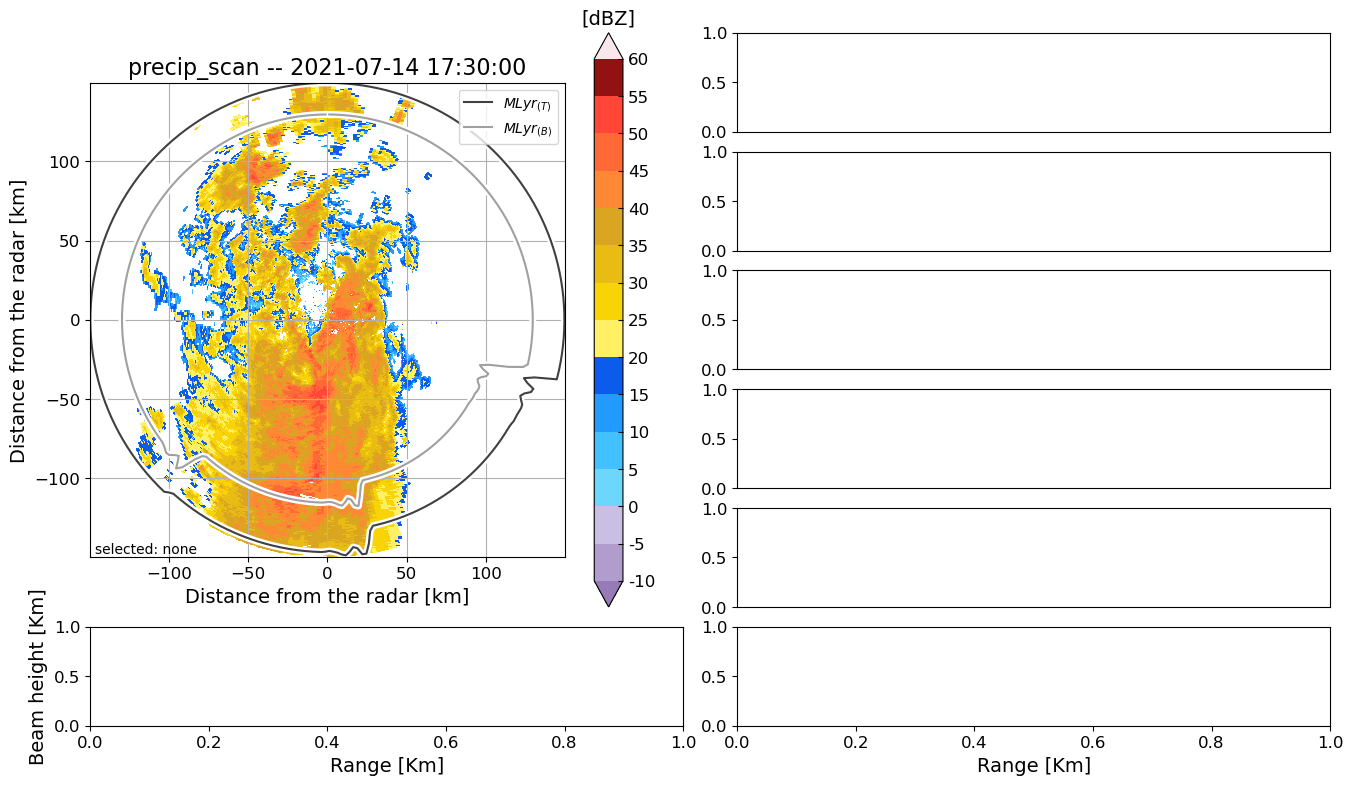

In [24]:
if PLOT_METHODS:
    tp.datavis.rad_interactive.ppi_base(
        rd_qcatc.georef, rd_qcatc.params,
        rd_qcatc.vars,
        # var2plot='AH [dB/km]',
        vars_bounds={'AH [dB/km]': [0, 0.2, 17],
                     'KDP [deg/km]': [-0.7, 2.1, 17]},
        # radial_xlims=(10, 62.5),
        # radial_ylims={'PhiDP [deg]': (-5, 270)},
        # ppi_xlims=[-40, 40], ppi_ylims=[-40, 40]
        mlyr=rmlyr)
    ppiexplorer = tp.datavis.rad_interactive.PPI_Int()

In [23]:
# %matplotlib inline

## References

- Bringi, V. N., Keenan, T. D., & Chandrasekar, V. (2001). Correcting C-band radar reflectivity and differential reflectivity data for rain attenuation: A self-consistent method with constraints. IEEE Transactions on Geoscience and Remote Sensing, 39(9), 1906–1915. https://doi.org/10.1109/36.951081
- Chen, J.-Y., Trömel, S., Ryzhkov, A., & Simmer, C. (2021). Assessing the benefits of specific attenuation for quantitative precipitation estimation with a C-band radar network. Journal of Hydrometeorology. https://doi.org/10.1175/JHM-D-20-0299.1
- Diederich, M., Ryzhkov, A., Simmer, C., Zhang, P., & Trömel, S. (2015). Use of Specific Attenuation for Rainfall Measurement at X-Band Radar Wavelengths. Part I: Radar Calibration and Partial Beam Blockage Estimation. Journal of Hydrometeorology, 16(2), 487–502. https://doi.org/10.1175/JHM-D-14-0066.1
- Heistermann, M., Jacobi, S., and Pfaff, T.: Technical Note: An open source library for processing weather radar data (wradlib), Hydrol. Earth Syst. Sci., 17, 863-871, doi:10.5194/hess-17-863-2013, 2013
- Park, S. G., Bringi, V. N., Chandrasekar, V., Maki, M., & Iwanami, K. (2005). Correction of radar reflectivity and differential reflectivity for rain attenuation at X band. Part I: Theoretical and empirical basis. Journal of Atmospheric and Oceanic Technology, 22(11), 1621–1632. https://doi.org/10.1175/JTECH1803.1
- Rico-Ramirez, M. A., & Cluckie, I. D. (2008). Classification of ground clutter and anomalous propagation using dual-polarization weather radar. IEEE Transactions on Geoscience and Remote Sensing, 46(7), 1892–1904. https://doi.org/10.1109/TGRS.2008.916979
- Rico-Ramirez, M. A. (2012). Adaptive attenuation correction techniques for C-band polarimetric weather radars. IEEE Transactions on Geoscience and Remote Sensing, 50(12), 5061–5071. https://doi.org/10.1109/TGRS.2012.2195228
- Ryzhkov, A. V., & Zrnic, D. S. (2019). Radar Polarimetry for Weather Observations. Springer International Publishing. https://doi.org/10.1007/978-3-030-05093-1
- Sanchez-Rivas, D., & Rico-Ramirez, M. A. (2021). Detection of the melting level with polarimetric weather radar. Atmospheric Measurement Techniques, 14(4), 2873–2890. https://doi.org/10.5194/amt-14-2873-2021
- Sanchez-Rivas, D., & Rico-Ramirez, M. A. (2022). Calibration of radar differential reflectivity using quasi-vertical profiles. Atmospheric Measurement Techniques, 15(2), 503–520. https://doi.org/10.5194/amt-15-503-2022
- Sanchez-Rivas, D., & Rico-Ramirez, M. A. (2023). Towerpy: An open-source toolbox for processing polarimetric weather radar data. Environmental Modelling & Software, 167, 105746. https://doi.org/10.1016/j.envsoft.2023.105746
- Trömel, S., Ziegert, M., Ryzhkov, A. V., Chwala, C., & Simmer, C. (2014). Using Microwave Backhaul Links to Optimize the Performance of Algorithms for Rainfall Estimation and Attenuation Correction. Journal of Atmospheric and Oceanic Technology, 31(8), 1748–1760. https://doi.org/10.1175/JTECH-D-14-00016.1
- Vulpiani, G., Montopoli, M., Passeri, L. D., Gioia, A. G., Giordano, P., & Marzano, F. S. (2012). On the Use of Dual-Polarized C-Band Radar for Operational Rainfall Retrieval in Mountainous Areas. Journal of Applied Meteorology and Climatology, 51(2), 405–425. https://doi.org/10.1175/JAMC-D-10-05024.1